In [247]:
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt

In [248]:
activation = [
    'relu',
    'sigmoid',
    'linear',
    'softmax',
]

In [249]:
class ActivationFunction:
    def __init__(self, activation_function):
        if activation_function == 'sigmoid':
            self.function = lambda net: 1 / (1 + np.exp(-net))
        elif activation_function == 'relu':
            self.function = lambda net: np.maximum(0, net)
        elif activation_function == 'linear':
            self.function = lambda net: net
        elif activation_function == 'softmax':
            self.function = lambda net: np.exp(net) / np.sum(np.exp(net))

    def get_activation_function(self):
        return self.function

In [250]:
class Layer:
    def __init__(self, neuron: int, activation_function: str, weights: np.array, bias: np.array):
        self.neuron = neuron
        self.weights = weights
        self.bias = bias
        if activation_function not in activation:
            raise Exception('Invalid activation function')
        else:
            self.activation_function = activation_function
            self.function = ActivationFunction(activation_function).get_activation_function()

    def forward(self, input: np.array):
        output = self.function(np.dot(input, self.weights) + self.bias)
        return np.round(output, decimals=7)

In [251]:
class FFNN:
    def __init__(self):
        self.layers = []
        self.node_bobots = []

    def add_layer(self, layer: Layer):
        self.layers.append(layer)

    def forward(self, input: np.array):
        output = input

        self.node_bobots.append(output[0])
        for layer in self.layers:
            output = layer.forward(output)
            temp_nodes = output[0].tolist()
            self.node_bobots.append(temp_nodes)
        return output

In [252]:
class NeuralNetworkGraph:
    def __init__(self):
        self.graphs = nx.DiGraph()
        self.node_labels = {}

    def add_nodes_layer(self, nodes, layer):
        self.graphs.add_nodes_from(nodes, layer=layer)

    def add_edge(self, node_source, node_goal):
        self.graphs.add_edge(node_source, node_goal)

    def add_all_nodes(self, node_bobots):

        # Add input bias label
        self.node_labels[0] = "Input"+str(0)+": "+str(1)

        node_number = 1

        self.add_nodes_layer([i for i in range(len(node_bobots[0])+1)], 0)

        # Add input label
        for i, node_value in enumerate(node_bobots[0]):
            self.node_labels[node_number] = "Input"+str(i+1)+": "+str(node_value)
            node_number += 1

        # Add nodes for each layer with the subset key
        for i in range(1, len(node_bobots)):
            self.node_labels[node_number] = "W"+str(i)+str(0)+": "+str(1)
            self.add_nodes_layer([node_number+j for j in range(len(node_bobots[i])+1)], i)
            node_number += 1
            for j in range(len(node_bobots[i])):
                self.node_labels[node_number] = "W"+str(i)+str(j+1)+": "+str(node_bobots[i][j])
                node_number += 1

        self.add_nodes_layer([node_number+j for j in range(len(node_bobots[-1]))], len(node_bobots))

        # Add output nodes
        for i, node_value in enumerate(node_bobots[-1]):
            self.node_labels[node_number] = "Output"+str(i+1)+": "+str(node_value)
            node_number += 1

    def add_all_edges(self, node_bobots):
        number_of_prev_neuron = 0
        curr_number_neuron = 0

        # Add edge for each node of input layer and hidden layer
        for layer_number in range(len(node_bobots)-1):
            curr_number_neuron += len(node_bobots[layer_number])+1

            for i in range(len(node_bobots[layer_number])+1):
                for j in range(len(node_bobots[layer_number+1])):
                    self.add_edge(number_of_prev_neuron, curr_number_neuron+j+1)
                number_of_prev_neuron += 1

        # Add edge for each node on output layer
        curr_number_neuron += len(node_bobots[-1])+1
        for i in range(len(node_bobots[-1])+1):
            for j in range(len(node_bobots[-1])):
                self.add_edge(number_of_prev_neuron, curr_number_neuron+j)
            number_of_prev_neuron += 1
        
        

In [254]:
model = open(f'../../Bagian-A/test/softmax.json', 'r')
model = json.load(model)

layers = model['case']['model']['layers']
weights = model['case']['weights']

ffnn = FFNN()
for i in range (len(layers)):
    layer = layers[i]
    weight = weights[i]
    ffnn.add_layer(Layer(layer["number_of_neurons"], layer["activation_function"], np.array(weight[1:]), np.array(weight[0])))
print("---------------------")
input = model["case"]["input"]

output = ffnn.forward(input).tolist()
print(ffnn.node_bobots)
print("---------------------")
expected_output = model['expect']['output']

print(f'output: {output}')
print(f'expected output: {expected_output}')

---------------------
[[-1.0, 0.5], [0.2592251, 0.7407749]]
---------------------
output: [[0.2592251, 0.7407749]]
expected output: [[0.2592, 0.7408]]


[0, 1, 2, 3, 4, 5, 6, 7]
{0: 'Input0: 1', 1: 'Input1: -1.0', 2: 'Input2: 0.5', 3: 'W10: 1', 4: 'W11: 0.2592251', 5: 'W12: 0.7407749', 6: 'Output1: 0.2592251', 7: 'Output2: 0.7407749'}


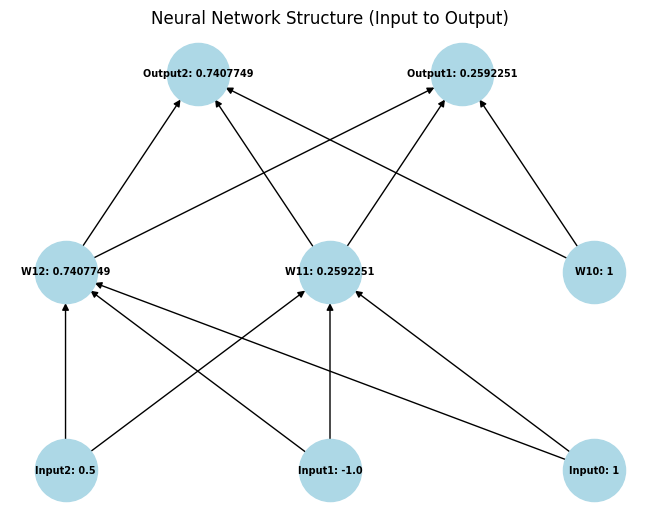

In [255]:
# Initialize a directed graph for visualization
neural_network_graph = NeuralNetworkGraph()

neural_network_graph.add_all_nodes(ffnn.node_bobots)

neural_network_graph.add_all_edges(ffnn.node_bobots)

print(neural_network_graph.graphs.nodes())
print(neural_network_graph.node_labels)

# Assuming neural_network_graph.graphs is your graph object
neural_network_graphs = neural_network_graph.graphs  # Assuming this is a correct reference

# Add 'layer' attribute to nodes if it's missing
for node in neural_network_graphs.nodes():
    if 'layer' not in neural_network_graphs.nodes[node]:
        neural_network_graphs.nodes[node]['layer'] = 0  # Set a default layer if needed

# Plot the neural network structure
pos = nx.multipartite_layout(neural_network_graphs, subset_key="layer", align='horizontal')
nx.draw(neural_network_graphs, pos, with_labels=True, labels=neural_network_graph.node_labels, node_size=2000, node_color="lightblue", font_size=7, font_weight="bold")

# Add edge labels for better understanding
edge_labels = {(u, v): f'' for u, v in neural_network_graphs.edges()}
nx.draw_networkx_edge_labels(neural_network_graphs, pos, edge_labels=edge_labels, font_color='red')

plt.title("Neural Network Structure (Input to Output)")
plt.axis('off')
plt.show()